# Looking into cross-correlation  
#### Joshua Poirier, [NEOS](http://www.neosgeo.com)  
2016 SEG Machine Learning Contest  

## 1 Introduction  

The purpose of this notebook is to examine the strength of cross-correlation between wells for the different features in our data set.  The idea is that we may be able to replace the **RELPOS** relative position feature with something more geologically (and predictively) meaningful.  The strata may be dipping, so a horizon (and thereby subsequent facies) may occur in the upper half in some wells but the lower half in others.  Let's demonstrate this with a simple synthetic example.  

In [2]:
# visualization packages
library(repr)
library(ggplot2)
library(ggthemes)
library(cowplot)

## 2 Synthetic example  

Let's create a synthetic binary log for seven wells.  Each show a 10 foot anomalous section offset from each other (dipping into the basin).

In [3]:
set.seed(3124)

# initialize with zero values
df <- data.frame(depth=rep(1:100,7),
                clean=rep(0,700),
                noisy=rep(0,700),
                well=c(rep("A",100),rep("B",100),rep("C",100),
                       rep("D",100),rep("E",100),rep("F",100),
                       rep("G",100)))

# add anomalies and noise
for (i in 1:7) {
    start <- (i-1)*100 + i*10
    end <- (i-1)*100 + i*10 + 10
    df$clean[start:end] <- 1
}
df$noisy <- df$clean + rnorm(700,0,.25)

head(df)

depth,clean,noisy,well
1,0,-0.33378482,A
2,0,-0.46925550,A
3,0,0.37076913,A
4,0,0.45729757,A
5,0,0.07645273,A
6,0,0.02481650,A


Now let's plot these wells.

In [4]:
# basic plotting function
plotLog <- function(x, isA=F) {
    names(x) <- c("Depth", "CleanLog", "NoisyLog", "Well")
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(-1,2)) + 
        scale_x_continuous(trans="reverse") + coord_flip() + labs(title="", x="", y=x$Well[1]) +
        geom_line(aes(x=Depth, y=CleanLog), lwd=.75, col="seagreen3") +
        geom_line(aes(x=Depth, y=NoisyLog), lwd=.75, col="firebrick") +
        geom_text(aes(x=0, y=.5, 
                      label="Green: True \n Red: Noisy data"), size=3, col="black") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    if (isA) {g <- g + labs(x="x") + theme(axis.text.y=element_text(size=6))}
    g <- switch_axis_position(g, 'x')
    g
}

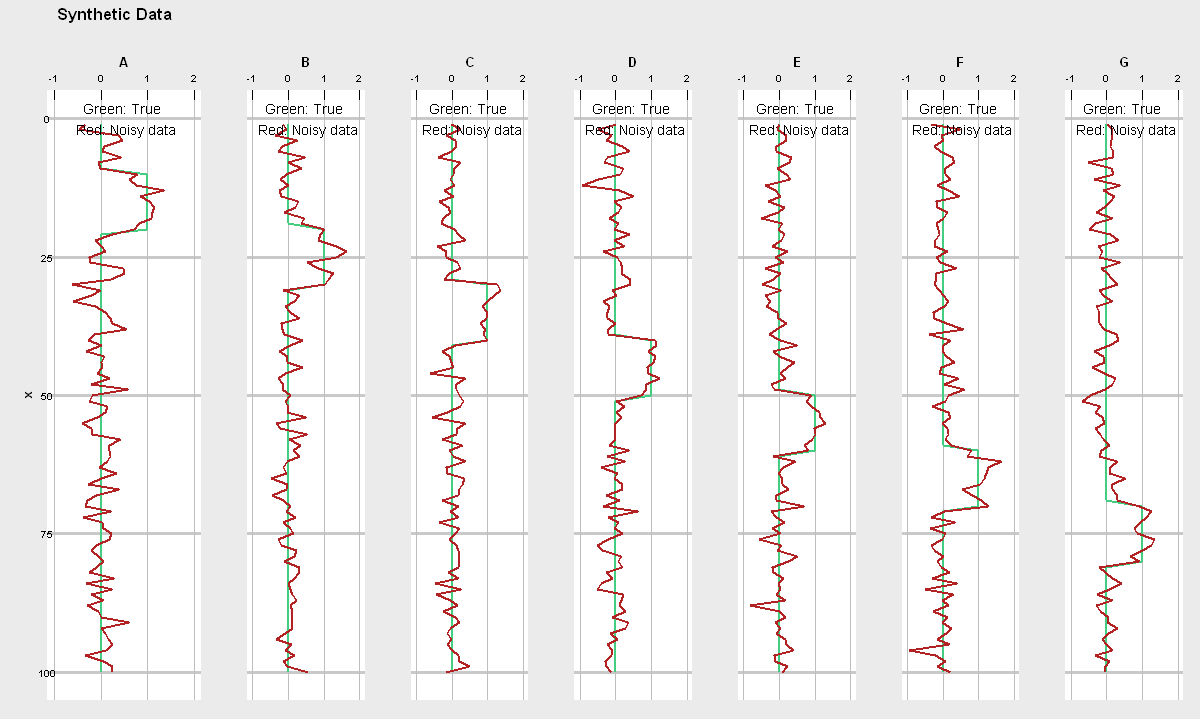

In [5]:
wells <- unique(df$well)
gs <- list()

# loop through wells - building track for each one
for (well in wells) {
    isA <- well == "A"
    gs[[well]] <- plotLog(df[df$well == well,],isA)
}

options(repr.plot.width=10, repr.plot.height=6)
g <- plot_grid(gs[["A"]], gs[["B"]], gs[["C"]], gs[["D"]], 
               gs[["E"]], gs[["F"]], gs[["G"]], ncol=7, rel_widths=c(4,3,3,3,3,3,3))
ggdraw() + draw_plot(g, width=1, height=1) + draw_plot_label("Synthetic Data", size=10)

If you look closely, we can qualitatively see there is a positive anomaly (centered around 1) in each of the wells.  Can we use **cross-correlation** to quantify how offset each of these wells are from each other?  Let's try!  We'll use well **A** as our reference well (i.e. what is the cross-correlation of wells **B**, **C**, and **D** with respect to well **A**.

In [64]:
wells <- unique(df$well)

# initialize data frames
lags <- data.frame(ref_well=factor(), well=factor(), lag=numeric())
max_cors <- data.frame(ref_well=factor(), well=factor(), max_corr=numeric())
ccf <- list()

# loop through matrix elements
for (i in wells) {
    temp <- list()
    v1 <- df[df$well==i,3]
    
    for (j in wells) {
        
        # extract relevant data vector    
        v2 <- df[df$well==j,3]
        
        # calculate cross-correlations
        temp[[j]] <- ccf(v1, v2, lag.max=75, plot=F)
        
        # store max correlation (and its corresponding lag) in matrix
        temp_lag <- data.frame(ref_well=i, well=j, 
                               lag=temp[[j]][["lag"]][,,1][which.max(temp[[j]][["acf"]][,,1])])
        temp_cor <- data.frame(ref_well=i, well=j,
                              max_corr=max(temp[[j]][["acf"]][,,1]))
        lags <- rbind(lags, temp_lag)
        max_cors <- rbind(max_cors, temp_cor)
    }
    
    ccf[[i]] <- temp
}

Ok so let's plot these results now!

In [65]:
# function to plot cross-correlation with respect to lag
plot_ccf <- function(x, title, isA=F) {
    names(x) <- c("lag", "acf")
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(-1,1)) + 
        scale_x_continuous(trans="reverse") + coord_flip() + 
        labs(title=title, x="", y="Cross \n Correlation") +
        geom_line(aes(x=lag, y=acf), lwd=.75, col="seagreen4") +
        geom_vline(xintercept=x$lag[which.max(x$acf)], col="firebrick", lwd=1) +
        geom_text(aes(x=x$lag[which.max(x$acf)]+2.5, y=0, 
                      label=paste("Corr:", round(max(x$acf),2))), size=2, col="firebrick") +
        geom_text(aes(x=x$lag[which.max(x$acf)]-2.5, y=0, 
                      label=paste("Lag:", x$lag[which.max(x$acf)])), size=2, col="firebrick") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=4), axis.title=element_text(size=8,face="bold"),
              title=element_text(size=6))
    if (isA) {g <- g + labs(x="Lag")}
    g <- switch_axis_position(g, 'x')
    g
}

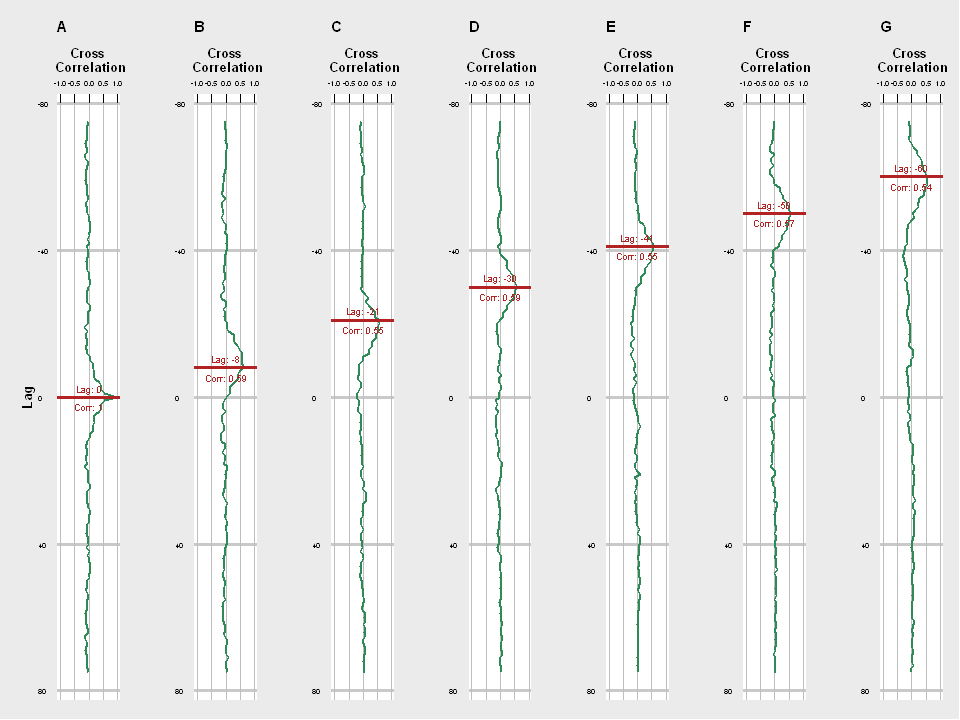

In [66]:
# initialize list of tracks
gs <- list()

# loop through wells and plot lag against correlation
# NOTE: only do with respect to "A" - otherwise too many plots
for (i in wells) {
    # extract lag and correlation vectors from cross-correlation list
    l <- ccf[["A"]][[i]][["lag"]][,,1]
    c <- ccf[["A"]][[i]][["acf"]][,,1]
    
    # store lag and correlation in dataframe for plotting
    temp_df <- data.frame(lag=l, corr=c)
    
    # build track
    gs[[i]] <- plot_ccf(temp_df, i, isA=(i == "A"))
}

# build and output plot
options(repr.plot.width=8, repr.plot.height=6)
g <- plot_grid(gs[["A"]], gs[["B"]], gs[["C"]], gs[["D"]], 
               gs[["E"]], gs[["F"]], gs[["G"]], ncol=7)
ggdraw() + draw_plot(g, width=1, height=1)

This result is as we expect it.  The cross-correlation technique does a good job of showing that each subsequent synthetic well is dipping into the basin with a **lag** set of **{0, -8, -21, -30, -41, -50, -60}**.  This is a good estimate of the true values of **{0, -10, -20, -30, -40, -50, -60}**.  

This result only shows the lags and correlations of the wells with respect to well **A**.  What about with respect to the other wells?  It would be too many tracks to plot all of them, so instead let's plot the matrices of lags and correlations as heat maps and see what patterns we can identify.

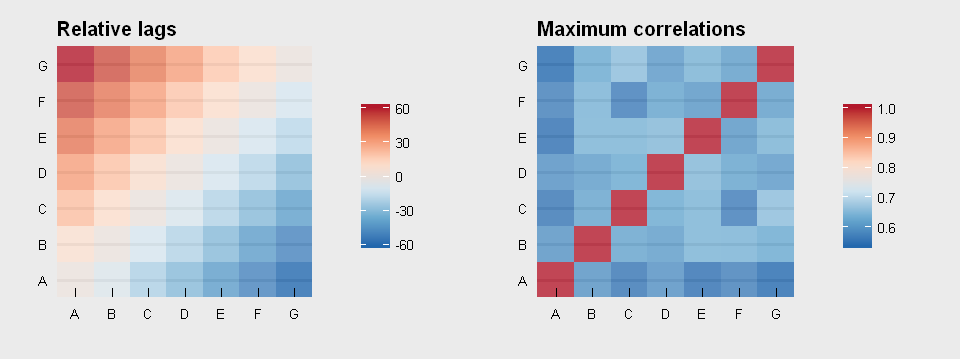

In [67]:
# build plot of lags
gl <- ggplot(lags, aes(well, ref_well)) + geom_tile(aes(fill=lag), alpha=.8) + theme_economist_white(gray_bg=T) +
    scale_x_discrete(expand = c(0, 0)) + scale_y_discrete(expand = c(0, 0)) +
    scale_fill_distiller(palette="RdBu") +
    labs(x="", y="", title="Relative lags") +
    theme(legend.position="right",
         legend.title=element_blank(),
         legend.text=element_text(size=8),
         axis.text=element_text(size=8),
         title=element_text(size=8))

# build plot of max correlations
gc <- ggplot(max_cors, aes(well, ref_well)) + geom_tile(aes(fill=max_corr), alpha=.8) + theme_economist_white(gray_bg=T) +
    scale_x_discrete(expand = c(0, 0)) + scale_y_discrete(expand = c(0, 0)) +
    scale_fill_distiller(palette="RdBu") +
    labs(x="", y="", title="Maximum correlations") +
    theme(legend.position="right",
         legend.title=element_blank(),
         legend.text=element_text(size=8),
         axis.text=element_text(size=8),
         title=element_text(size=8))

# bring the two plots together and display
options(repr.plot.width=8, repr.plot.height=3)
g <- plot_grid(gl, gc, ncol=2)
ggdraw() + draw_plot(g, width=1, height=1)

Not surprisingly, **A**'s autocorrelation (with itself) maximizes at zero-lag with a correlation of 1!  Also, even with noise added to the data, the cross-correlation determines the lag/offset of wells **B**, **C**, and **D** quite accurately.  **C** is the only well off at all - and it's off by only 1 foot, not bad!  Now let's try applying this idea to some real data!  

## 3 Real data example  

The data we'll be looking at comes from a class exercise from the University of Kansas on neural networks and fuzzy systems.  The exercise was based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America (Hugoton and Panoma fields).  We will be looking (in this notebook) at a subset of this data - well logs from the **Luke G U**, **Shrimplin**, and **Newby** wells.  

First let's define a function to plot an individual well log.

In [68]:
facies_colors <- c('#F4D03F', '#F5B041', '#DC7633', '#6E2C00', '#1B4F72', '#2E86C1', '#AED6F1', '#A569BD', '#196F3D')
facies_labels <- c('SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS')

# GR track - gamma ray
plotGR <- function(x, asWell=F) {
    g <- ggplot(x) + theme_economist_white(gray_bg=T) + 
        scale_y_continuous(lim=c(0,400), breaks=seq(0,400,100), labels=c("0"="0","100"="","200"="200","300"="","400"="400")) +
        scale_x_continuous(trans="reverse") + coord_flip() + labs(title="", x="Depth", y="GR") +
        geom_bar(stat="identity", data=x, aes(x=Depth, y=GR, fill=GR, alpha=0.5), width=0.5) +
        geom_line(aes(x=Depth, y=GR), lwd=.5, col='black') +
        scale_fill_continuous(limits=c(0,225), low="yellow", high="black") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.5), legend.position="none",
             axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"))
    if (asWell) {g <- g + labs(y=x$Well.Name[1])}
    if (asWell & x$Well.Name[1] != "CROSS H CATTLE") {g <- g + labs(x="")}
    g <- switch_axis_position(g, 'x')
    g
}

# ILD track - resistivity
plotILD <- function(x, asWell=F) {
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_log10(lim=c(0.1,50), breaks=c(.1,.2,.4,.6,.8,1,2,4,6,8,10,20,40), 
                      labels=c(".1"=".1",".2"="",".4"="",".6"="",".8"="",
                               "1"="1","2"="","4"="","6"="","8"="","10"="10",
                              "20"="","40"="")) + 
        scale_x_continuous(trans="reverse") + 
        coord_flip() + labs(title="", x="", y="ILD") +
        geom_line(aes(x=Depth, y=10^ILD_log10), lwd=.5, col="skyblue4") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    if (asWell) {g <- g + labs(y=x$Well.Name[1]) + theme(axis.text.y=element_text(size=6))}
    if (asWell & x$Well.Name[1] == "CROSS H CATTLE") {g <- g + labs(x="Depth")}
    g <- switch_axis_position(g, 'x')
    g
}

# DeltaPhi track - difference between density and neutron porosities
plotDeltaPHI <- function(x, asWell=F) {
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(-20,20), breaks=seq(-20,20,10),labels=c("-20"="-20","-10"="","0"="0","10"="","20"="20")) + 
        scale_x_continuous(trans="reverse") + coord_flip() + labs(title="", x="", y="DeltaPhi") +
        geom_line(aes(x=Depth, y=DeltaPHI), lwd=.5, col="seagreen4") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    if (asWell) {g <- g + labs(y=x$Well.Name[1]) + theme(axis.text.y=element_text(size=6))}
    if (asWell & x$Well.Name[1] == "CROSS H CATTLE") {g <- g + labs(x="Depth")}
    g <- switch_axis_position(g, 'x')
    g
}

# PHIND track - neutron porosity
plotPHIND <- function(x, asWell=F) {
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(0,50), breaks=c(0,15,30,45)) + scale_x_continuous(trans="reverse") +
        coord_flip() + labs(title="", x="", y="PHIND") +
        geom_line(aes(x=Depth, y=PHIND), lwd=.5, col="firebrick") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    if (asWell) {g <- g + labs(y=x$Well.Name[1]) + theme(axis.text.y=element_text(size=6))}
    if (asWell & x$Well.Name[1] == "CROSS H CATTLE") {g <- g + labs(x="Depth")}
    g <- switch_axis_position(g, 'x')
    g
}

# PE track - photoelectric effect
plotPE <- function(x, asWell=F) {
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(0,8), breaks=c(0,2,4,6,8)) + scale_x_continuous(trans="reverse") +
        coord_flip() + labs(title="", x="", y="PE") +
        geom_line(aes(x=Depth, y=PE), lwd=.5, col="black") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    if (asWell) {g <- g + labs(y=x$Well.Name[1]) + theme(axis.text.y=element_text(size=6))}
    if (asWell & x$Well.Name[1] == "SHRIMPLIN") {g <- g + labs(x="Depth")}
    g <- switch_axis_position(g, 'x')
    g
}

# isMarine track - indicator showing whether or not it's marine
plotIsMarine <- function(x, asWell=F) {
    x$ones <- rep(1, nrow(x))
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(-0.1,1.1), breaks=c(0,1), labels=c("TRUE"="", "FALSE"="")) + 
        scale_x_continuous(trans="reverse") +
        coord_flip() + labs(title="", x="", y="isMarine") +
        geom_bar(stat="identity", data=x, aes(x=Depth, y=ones, fill=isMarine), width=0.5) +
        scale_fill_manual(values=c("TRUE"="springgreen3", "FALSE"="firebrick"), drop=F) +
        theme(axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank(), axis.text.x=element_text(size=6), 
              legend.position="none")
    if (asWell) {g <- g + labs(y=x$Well.Name[1]) + theme(axis.text.y=element_text(size=6))}
    if (asWell & x$Well.Name[1] == "CROSS H CATTLE") {g <- g + labs(x="Depth")}
    g <- switch_axis_position(g, 'x')
    g
}

# facies track
plotFacies <- function(x, asWell=F) {
    x$ones <- rep(1, nrow(x))
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(-0.1,1.1), breaks=c(0,1), labels=c("0"="", "1"="")) + scale_x_continuous(trans="reverse") +
        coord_flip() + labs(title="", x="", y="Facies") +
        geom_bar(stat="identity", data=x, aes(x=Depth, y=ones, fill=Facies), width=0.5) +
        scale_fill_manual(values=facies_colors, drop=F, labels=facies_labels) +
        theme(axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank(), axis.text.x=element_text(size=6), 
              legend.position="right", legend.text=element_text(size=6), legend.title=element_blank())
    if (asWell) {g <- g + labs(y=x$Well.Name[1]) + theme(axis.text.y=element_text(size=6))}
    if (asWell & x$Well.Name[1] == "CROSS H CATTLE") {g <- g + labs(x="Depth")}
    if (asWell & x$Well.Name[1] != "KIMZEY A") {g <- g + theme(legend.position="none")}
    g <- switch_axis_position(g, 'x')
    g
}

Our goal will be to establish the amount of **lag** between these two wells that maximizes their correlation.  As with the synthetic data, we will plot the **correlation-lag** plots to better understand that relationship, and whether it may be used with confidence moving forward.  To evaluate, we will use the **Luke G U** well as our control and apply cross-correlation to the **GR**, **ILD_log10**, **DeltaPHI**, **PHIND**, **PE**, and **isMarine** logs individually.  

In [69]:
# load data
fname <- "../facies_vectors.csv"
data <- read.csv(fname, colClasses=c(rep("factor",3), rep("numeric",6), "factor", "numeric"))

# convert NM_M channel into a binary channel "isMarine"
data$NM_M <- data$NM_M == "2"
names(data)[10] <- "isMarine"

# make the Facies channel more descriptive
levels(data$Facies) <- c("SS", "CSiS", "FSiS", "SiSh", "MS", "WS", "D", "PS", "BS")

# display first five rows of data set
head(data)

Facies,Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,isMarine,RELPOS
FSiS,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,FALSE,1.000
FSiS,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,FALSE,0.979
FSiS,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,FALSE,0.957
FSiS,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,FALSE,0.936
FSiS,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,FALSE,0.915
FSiS,A1 SH,SHRIMPLIN,2795.5,73.97,0.636,14.0,13.385,3.6,FALSE,0.894


Before diving into the individual data types, let's build some functions to help reuse code.  First, let's build a function that plots the data and cross-correlation (as a function of lag) for three sample wells.  Here, we'll show the **LUKE G U**, **SHRIMPLIN**, and **NEWBY** wells.

In [70]:
buildXCorrSamplePlot <- function(data, sampleWells, plotFunction, title="") {
    
    # split data into recognizable vectors
    d1 <- data[data$Well.Name==sampleWells[1], 3]
    d2 <- data[data$Well.Name==sampleWells[2], 3]
    d3 <- data[data$Well.Name==sampleWells[3], 3]
    
    # calculate cross-correlations for sample vectors (relative to first sample well)
    ccf1 <- ccf(d1, d1, lag.max=100, plot=F)
    ccf2 <- ccf(d1, d2, lag.max=100, plot=F)
    ccf3 <- ccf(d1, d3, lag.max=100, plot=F)
    
    # place cross-correlations (as a function of lag) into data frame
    real_df <- data.frame(lag=ccf1[["lag"]][,,1],
                         ccf1=ccf1[["acf"]][,,1],
                         ccf2=ccf2[["acf"]][,,1],
                         ccf3=ccf3[["acf"]][,,1])
    
    # build data log plots for each well
    g1 <- plotFunction(data[data$Well.Name==sampleWells[1],], T)
    g2 <- plotFunction(data[data$Well.Name==sampleWells[2],], T)
    g3 <- plotFunction(data[data$Well.Name==sampleWells[3],], T)
    
    # build cross-correlation plots for each well
    g4 <- plot_ccf(real_df[,c(1,2)], "")
    g5 <- plot_ccf(real_df[,c(1,3)], "")
    g6 <- plot_ccf(real_df[,c(1,4)], "")
    
    # display the sample wells' data and cross-correlation
    options(repr.plot.width=8, repr.plot.height=6)
    g <- plot_grid(g1, g4, g2, g5, g3, g6, ncol=6, rel_widths=c(3,4,3,4,3,4))
    ggdraw() + draw_plot(g, width=1, height=1) + draw_plot_label(title, size=10)
}

### 3.1 GR Gamma ray cross-correlation  

Let's use the **LUKE G U**, **SHRIMPLIN**, and **NEWBY** wells to examine the cross-correlation of the **GR** data.

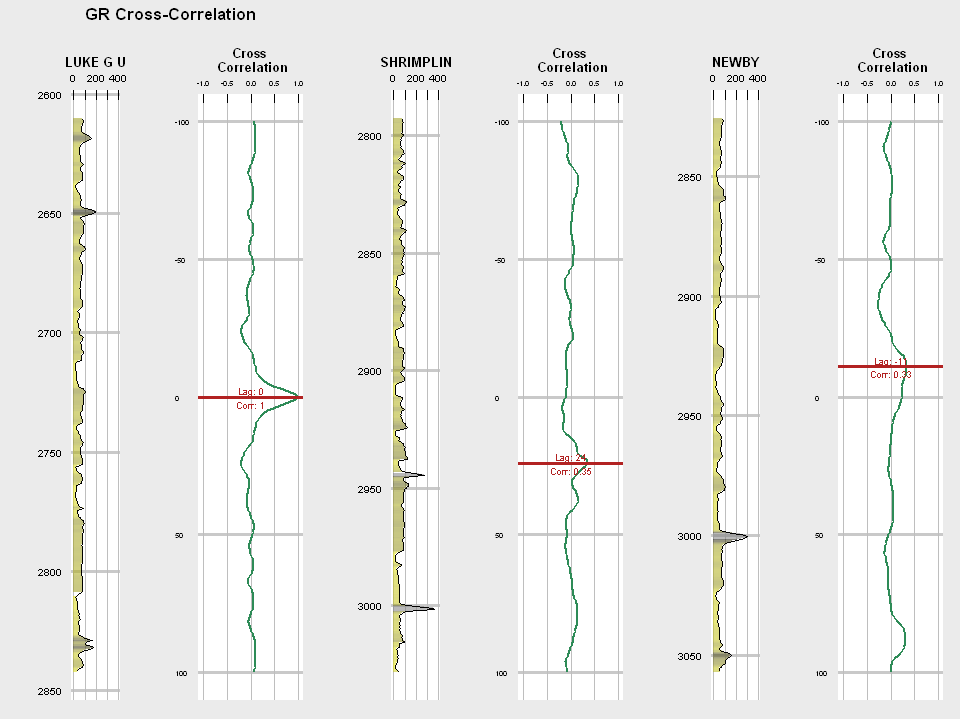

In [72]:
sampleWells <- c("LUKE G U", "SHRIMPLIN", "NEWBY")
buildXCorrSamplePlot(data[,c(3,4,5)], sampleWells, plotGR, "GR Cross-Correlation")

In [25]:
wells <- unique(data$Well.Name)

# initialize data frames
lags <- data.frame(ref_well=factor(), well=factor(), lag=numeric())
max_cors <- data.frame(ref_well=factor(), well=factor(), max_corr=numeric())
ccf <- list()

# loop through matrix elements
for (i in wells) {

    temp <- list()
    v1 <- data[data$Well.Name==i,5]
    
    for (j in wells) {
        
        # extract relevant data vector
        v2 <- data[data$Well.Name==j,5]

        # calculate cross-correlations
        temp[[j]] <- ccf(v1, v2, lag.max=75, plot=F)
        
        # store max correlation (and its corresponding lag) in data frame
        temp_lag <- data.frame(ref_well=i, well=j,
                              lag=temp[[j]][["lag"]][,,1][which.max(temp[[j]][["acf"]][,,1])])
        temp_cor <- data.frame(ref_well=i, well=j,
                              max_corr=max(temp[[j]][["acf"]][,,1]))
        lags <- rbind(lags, temp_lag)
        max_cors <- rbind(max_cors, temp_cor)
    }
    
    ccf[[i]] <- temp
}

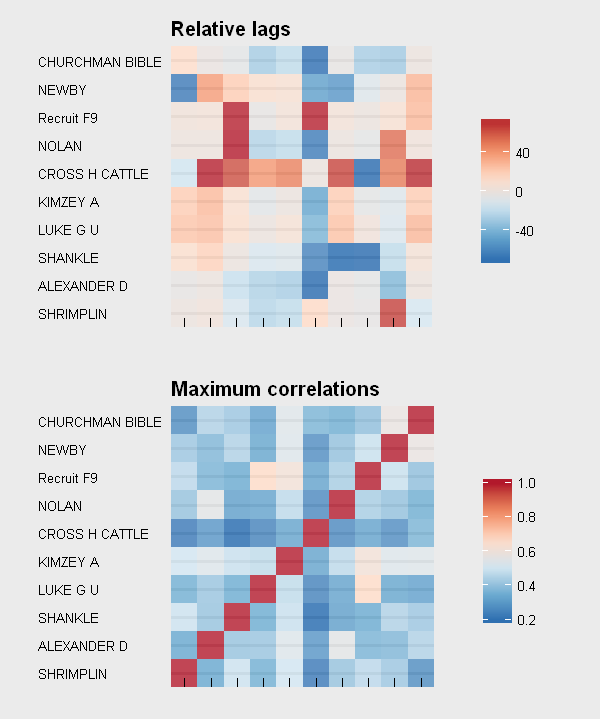

In [31]:
# build plot of lags
gl <- ggplot(lags, aes(well, ref_well)) + geom_tile(aes(fill=lag), alpha=.8) + theme_economist_white(gray_bg=T) +
    scale_x_discrete(expand = c(0, 0)) + scale_y_discrete(expand = c(0, 0)) +
    scale_fill_distiller(palette="RdBu") +
    labs(x="", y="", title="Relative lags") +
    theme(legend.position="right",
         legend.title=element_blank(),
         legend.text=element_text(size=8),
         axis.text=element_text(size=8),
         axis.text.x=element_blank(),
         title=element_text(size=8))

# build plot of max correlations
gc <- ggplot(max_cors, aes(well, ref_well)) + geom_tile(aes(fill=max_corr), alpha=.8) + theme_economist_white(gray_bg=T) +
    scale_x_discrete(expand = c(0, 0)) + scale_y_discrete(expand = c(0, 0)) +
    scale_fill_distiller(palette="RdBu") +
    labs(x="", y="", title="Maximum correlations") +
    theme(legend.position="right",
         legend.title=element_blank(),
         legend.text=element_text(size=8),
         axis.text=element_text(size=8),
         axis.text.x=element_blank(),
         title=element_text(size=8))

# bring the two plots together and display
options(repr.plot.width=5, repr.plot.height=6)
g <- plot_grid(gl, gc, ncol=1)
ggdraw() + draw_plot(g, width=1, height=1)